## This Notebook Uses The Amazon Reviews Dataset And Predict Whether The Review Is Positive Or Negative Using The Naive Bayes Classifier

Source of data = https://www.kaggle.com/snap/amazon-fine-food-reviews 

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import sqlite3
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.sparse as mat
import warnings
warnings.filterwarnings("ignore")

In [198]:
con = sqlite3.connect('database.sqlite')
data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 LIMIT 350000""",con)

In [199]:
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [200]:
type(data)

pandas.core.frame.DataFrame

In [201]:
data.shape

(350000, 10)

In [202]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [203]:
data['ProductId'].nunique()

47260

In [204]:
data['UserId'].nunique()

181835

In [205]:
# To predict the polarity of review, we have to use the scores provided in the data and hence we will convert the score
# into binary values
def Classifier(x):
    if x<3:
        return 0
    return 1
data['Score']=data['Score'].map(Classifier)

In [206]:
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [207]:
# Exploring the data for data inconsistencies
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId,ProductId
HAVING COUNT(*)>1
""", con)

In [208]:
display.head(2)

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,A102TGNH1D915Z,B00008DFK5,LINDA Riley,1262131200,4,"Although the product can be a bit pricey, it c...",2
1,A102TGNH1D915Z,B0002DHNXC,LINDA Riley,1262131200,4,"Although the product can be a bit pricey, it c...",2


### Why there are duplicate entries of users at the same time?

Row 1 and 2 shows something which is not possible, which is, 2 products with different ids were bought at the same time.
So I went to the amazon product page with these ids and saw something, which I could have known(Thanks to appliedaicourse.com for their amazing teaching skills)
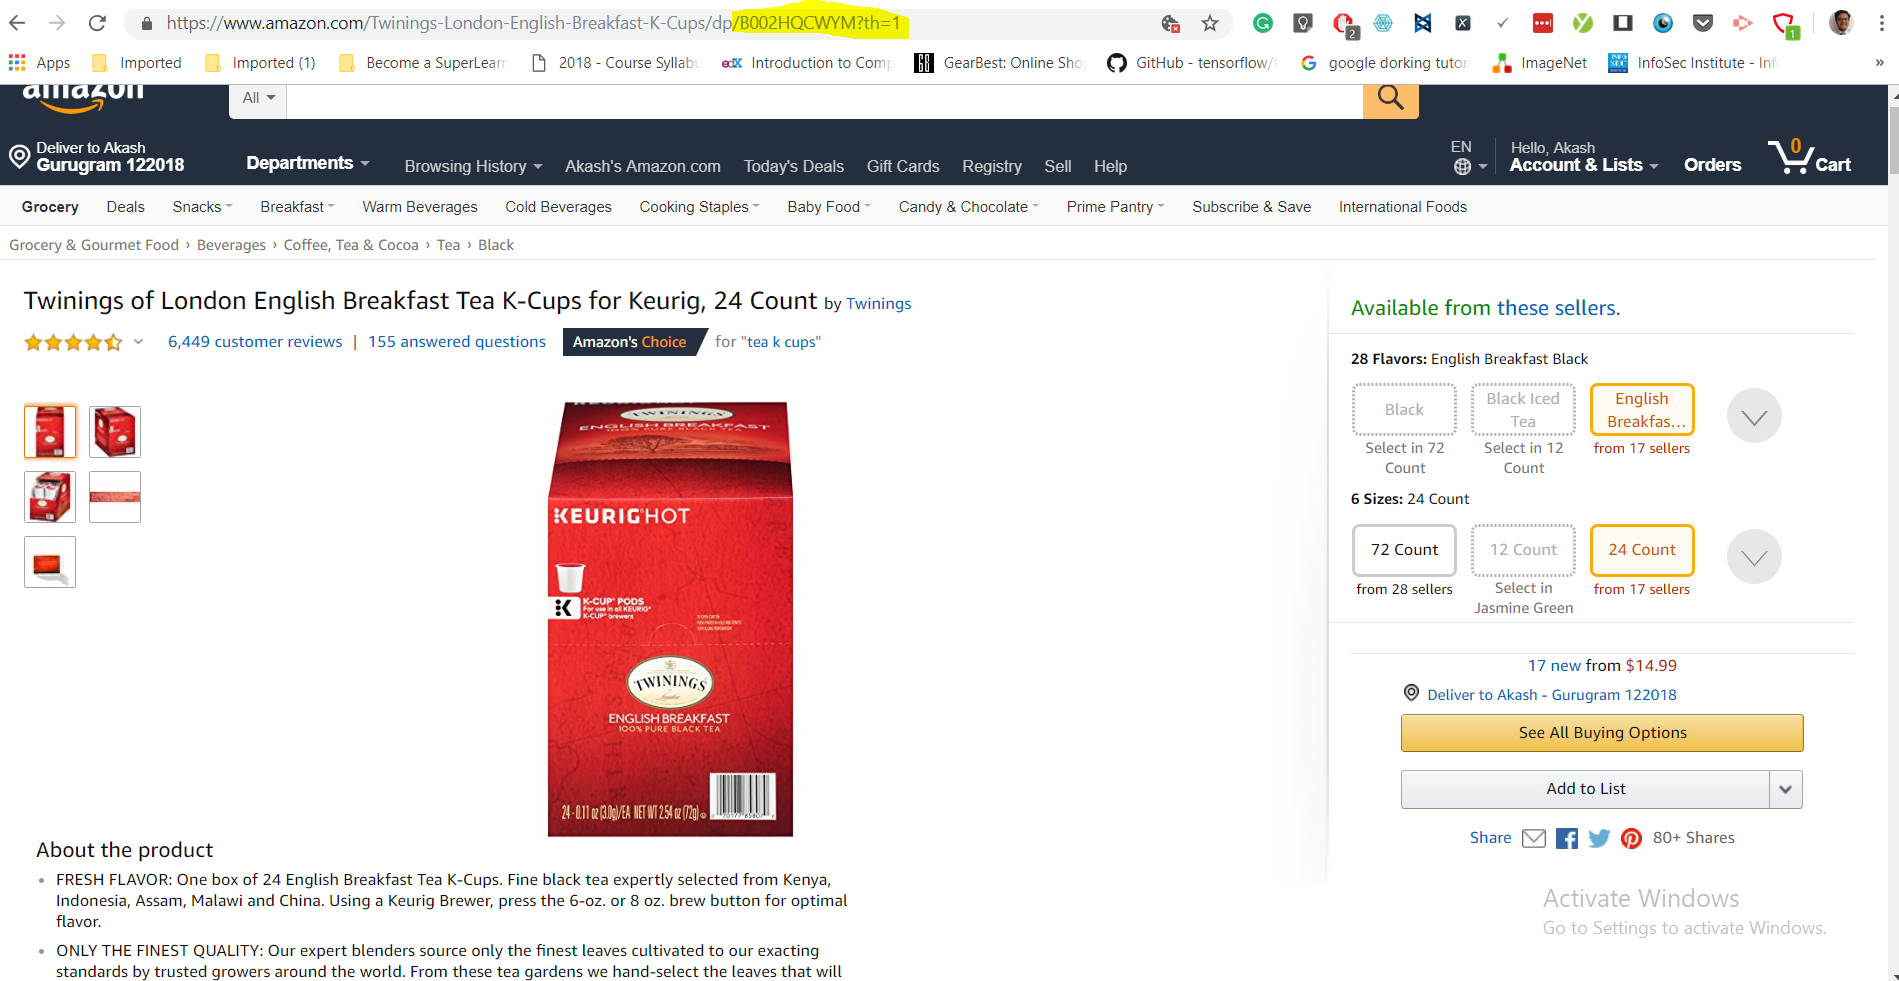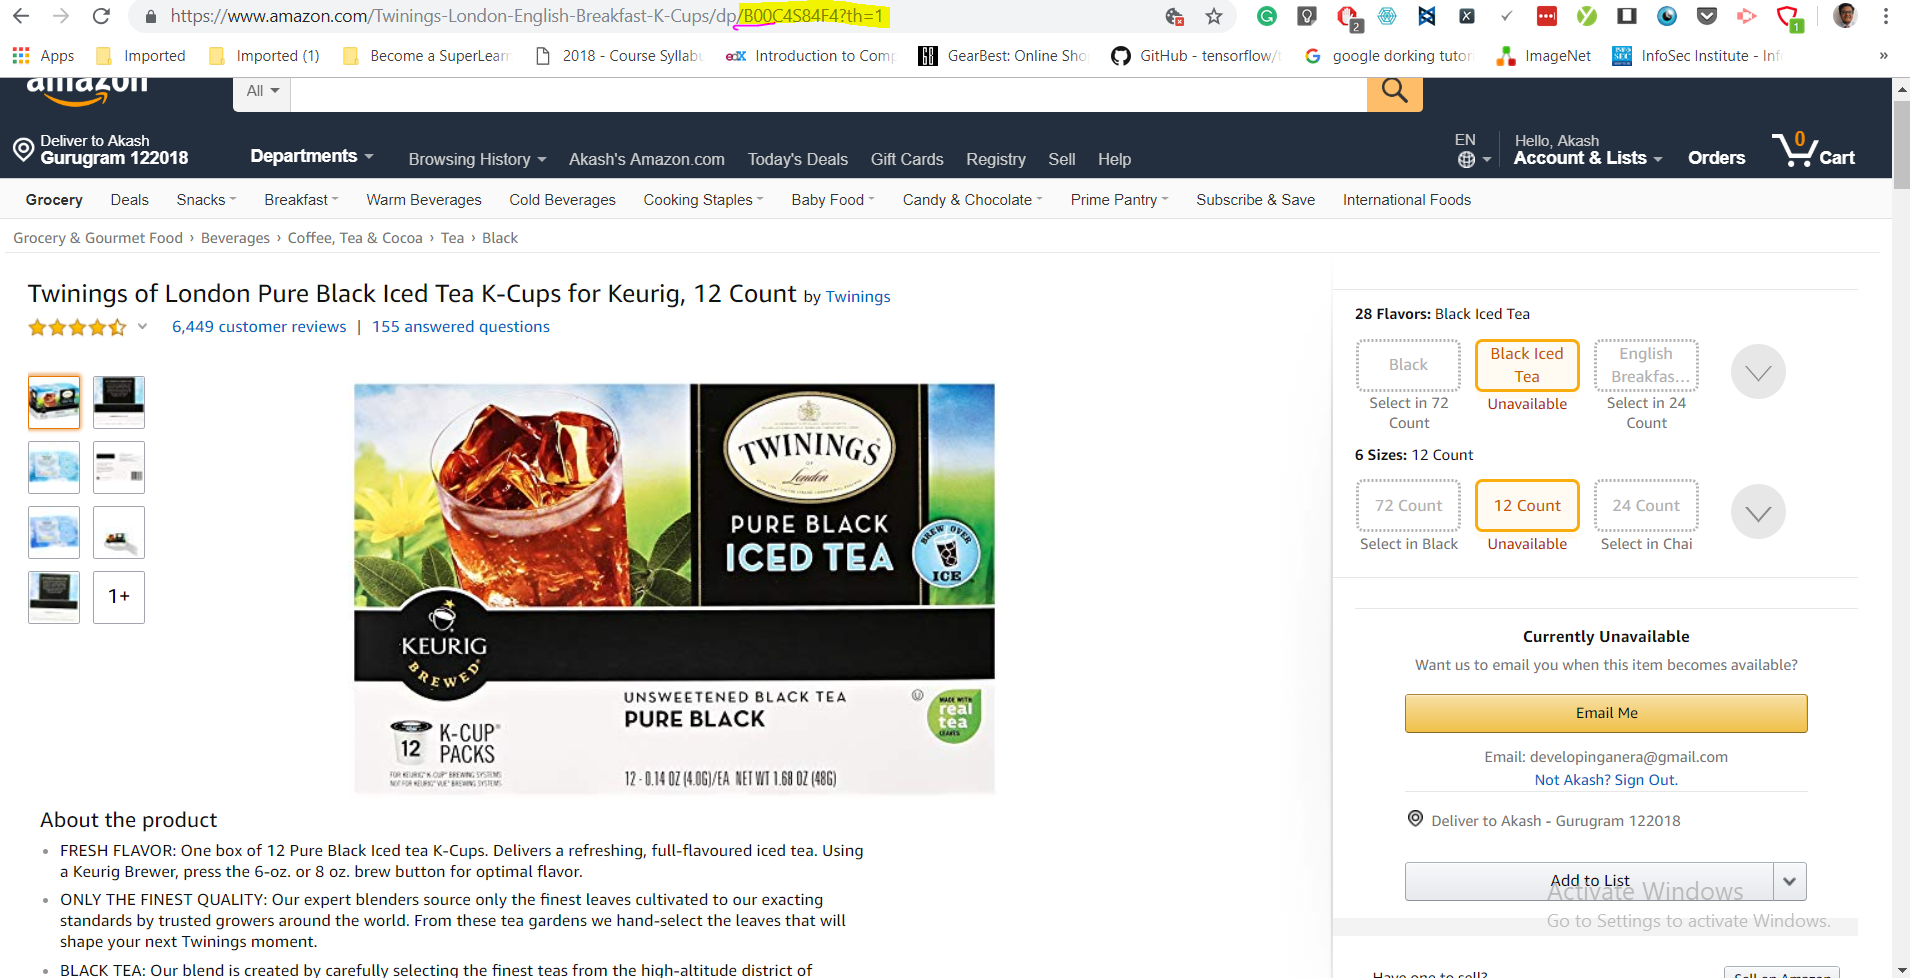

As we can see that the 2 variations of the same product has 2 different product ids, but the reviews are same for both of the products. This was the reason for duplication of rows. Now we will remove those duplicated rows keeping only the first entry

In [209]:
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [210]:
sorted_data = data.sort_values(by = 'ProductId', inplace = False)

In [211]:
sorted_data.shape

(350000, 10)

In [212]:
#Dropping the duplicates
filtered_data = sorted_data.drop_duplicates(subset ={'UserId','ProfileName','Time','Summary'})

In [213]:
filtered_data.shape

(255897, 10)

In [214]:
data.shape

(350000, 10)

In [215]:
# Now Dropping the rows with no values
final_data=filtered_data.dropna()

In [216]:
final_data.shape

(255897, 10)

No rows were found with missing data, which is great!!!

In [217]:
final_data[final_data['HelpfulnessDenominator']<final_data['HelpfulnessNumerator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


What I find now is that there are 2 data point where helpfulness denominator is greater than numerator in my 5000 rows

In [218]:
final=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [219]:
final.shape

(255895, 10)

In [220]:
final.Score.value_counts(normalize=True)

1    0.84165
0    0.15835
Name: Score, dtype: float64

84% of the reviews are positive, and 16% are negative.

In [221]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,1,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138709,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,1,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...


In [222]:
final_data= data

#### Adding another feature - length of text of review

In [223]:
len_rev =[len(i) for i in final_data['Text']]
final_data['length'] = len_rev

#### Sorting according to time, so that we can do time-based split

In [224]:
# sorting the data by time, so that we can do timebased splitting.
final_data.sort_values('Time',inplace=True,ascending=True)

In [225]:
final_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,375
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,407


In [226]:
final_data.Text[4133]  # after randomly reading the reviews, i saw that the reviews had many tags.

'Love this stuff!  I add some diced tomatoes and a pound of ground hamburger and this is great!  I take it to pot lucks a lot.'

In [227]:
final_data.shape

(350000, 11)

##### We will split the data, after cleaning it

## Preprocessing the text

All the credits to AAIC team for wonderful course.
1. Begin by removing the html tags, we will use beautiful soup for this.
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Wordnet lemmatizer as it is better than snowball stemmer

In [228]:
# importing the libraries needed
import re
import nltk
import string
from bs4 import BeautifulSoup

In [229]:
stopword = nltk.corpus.stopwords.words('english')


In [230]:
lemm = nltk.stem.wordnet.WordNetLemmatizer()
stemm = nltk.stem.SnowballStemmer('english')

In [231]:
#this is how the lemmatizer works
lemm.lemmatize('communities')

'community'

In [232]:
stemm.stem('communities')

'communiti'

In [233]:
stopword = set(stopword)

We will use lemmatizer as it makes use of dictionary and is good for our problem

###  preprocessing the text

In [234]:
def cleaner(phrase):
    # decontraction
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)  # r means raw string
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    #removing words with numbers and special characters
    phrase = re.sub(r"\d\S","", phrase)
    phrase = re.sub(r"\S*\d\S","", phrase).strip()
    phrase = re.sub(r"[^A-Za-z0-9]+"," ",phrase)
    return phrase

In [235]:
from tqdm import tqdm
cleaned_text = []
words = []
for sent in tqdm(final_data['Text'].values):
    sent = BeautifulSoup(sent,'lxml').get_text()
    sent = cleaner(sent)
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopword)
    sent = ' '.join(lemm.lemmatize(e) for e in sent.split())
    cleaned_text.append(sent)

100%|████████████████████████████████████████████████████████████████████████| 350000/350000 [05:46<00:00, 1010.54it/s]


In [236]:
from tqdm import tqdm
cleaned_summary = []

for sent in tqdm(final_data['Summary'].values):
    sent = BeautifulSoup(sent,'lxml').get_text()
    sent = cleaner(sent)
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopword)
    sent = ' '.join(lemm.lemmatize(e) for e in sent.split())
    cleaned_summary.append(sent)

100%|████████████████████████████████████████████████████████████████████████| 350000/350000 [02:46<00:00, 2105.89it/s]


In [237]:
d = {
    'text':cleaned_text,
    'summary':cleaned_summary,
    'length':len_rev
}

In [238]:
df1 = pd.DataFrame(d)

In [239]:
df1['text+summary'] = df1['text'].map(str)+df1['summary']

In [240]:
df1  =df1.drop(columns=['text','summary'])

#### Two Functions That We Will Use

In [241]:
def finding_right_alpha_model(xtrain,ytrain,xcross,ycross):

    error_on_cv=[]
    error_on_train = []
    roc_cv1 = []
    roc_tr1 = []
    alphas= np.array([0.00001,0.0001,0.001,0.01,0.1,1,2])
    for i in tqdm(alphas):
        nb = MultinomialNB(alpha=i, fit_prior=True, class_prior=None)

        # fitting the model on crossvalidation train
        nb.fit(xtrain, ytrain)

        # predict the response on the crossvalidation train
        pred = nb.predict_proba(xcross)[:,1]
        pred1 = nb.predict_proba(xtrain)[:,1]

        #ROC_AUC SCORE
        roc_cv= roc_auc_score(ycross,pred)
        roc_cv1.append(roc_cv)
        roc_tr =roc_auc_score(ytrain,pred1)
        roc_tr1.append(roc_tr)
    
    #plotting the roc-auc
    plot1= plt.subplot(1,1,1)
    plt.grid()
    plt.title("Area Under Roc Curve for Train and Cv Data")
    plt.plot(alphas,roc_cv1,label="roc_auc_cv")
    plt.plot(alphas,roc_tr1,label ="roc_auc_tr")
    plt.xlabel('ALPHA')
    plt.ylabel('Area under curve of ROC')
    plt.legend()
    plt.show()



In [277]:
def final_model(xtrain,ytrain,xtestdata,ytestdata,right_alpha):
    # Training the model with the right parameter

    nb = MultinomialNB(alpha=right_alpha, fit_prior=True, class_prior=None)

    # fitting the model on crossvalidation train
    nb.fit(xtrain, ytrain)

    # predict the response on the crossvalidation train
    pred = nb.predict_proba(xtestdata)[:,1]
    pred1 = nb.predict_proba(xtrain)[:,1]
    
    #plotting the roc 
    final_auc_score= roc_auc_score(ytestdata,pred)
    print("*******Final Auc Score is {}*********".format(final_auc_score))
    
    print("**********Negative Class important features are********")
    
    neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
    pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()

    print(np.take(bow.get_feature_names(), neg_class_prob_sorted[:10]))
    print("**********Positive Class important features are********")
    print(np.take(bow.get_feature_names(), pos_class_prob_sorted[:10]))

    
    fpr,tpr,threshold = roc_curve(ytestdata,pred)
    fpr1,tpr1,threshold1 = roc_curve(ytrain,pred1)
    plt.figure(2,figsize = (15,4))
    plt.subplot(1,2,1)
    plt.title("Roc Curve For Train and Test Data")
    plt.plot(fpr,tpr,label = "test-roc")
    plt.plot(fpr1,tpr1,label = "train-roc")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    #plotting the confusion matrix
    plt.subplot(1,2,2)
    cm = confusion_matrix(ytestdata,nb.predict(xtestdata))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d",center =None)
    plt.title("Confusion Matrix")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.show()

### Text Featurization

#### BAG OF WORDS

In [243]:
df1.shape

(350000, 2)

In [244]:
# splitting the dataframe into train,test,cv dataset 
from sklearn.model_selection import train_test_split as splitter
x,xtest,y,ytest = splitter(df1,final_data['Score'],test_size = 0.2)
xtr,xcv,ytr,ycv = splitter(x,y,test_size=0.2)

In [245]:
#Using Bag of words on text and summary and adding another feature
import sklearn.feature_extraction.text as textfeat
bow = textfeat.CountVectorizer()
bow.fit(xtr['text+summary'])
bow_xtr= bow.transform(xtr['text+summary'])
bow_xcv = bow.transform(xcv['text+summary'])
bow_xtest = bow.transform(xtest['text+summary'])

In [251]:
bow_xtest.shape

(70000, 182194)

In [247]:
xtr.shape

(224000, 2)

In [249]:
bow_with_other_features_train = mat.hstack([bow_xtr,np.array(xtr['length']).reshape(224000,1)]) # reshaping for 2-d conversion

In [ ]:
xcv.shape

In [253]:
bow_with_other_features_cv = mat.hstack([bow_xcv,np.array(xcv['length']).reshape(56000,1)])

In [254]:
xtest.shape

(70000, 2)

In [255]:
bow_with_other_features_test = mat.hstack([bow_xtest,np.array(xtest['length']).reshape(70000,1)])

#### applying multinomial naive bayes

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.16it/s]


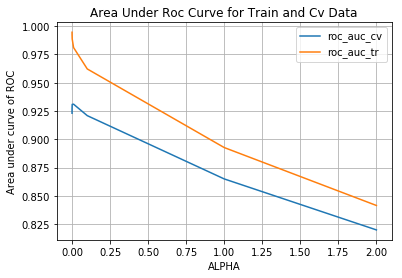

In [256]:
finding_right_alpha_model(bow_with_other_features_train,ytr,bow_with_other_features_cv,ycv)

*******Final Auc Score is 0.9214995471991962*********
**********Negative Class important features are********
['0benecol' 'orderreal' 'orderreally' 'orderreese' 'orderremember'
 'orderreveiew' 'orderreview' 'orderraw' 'orderreviewing' 'orderroland']
**********Positive Class important features are********
['drinkingstrong' 'buyawful' 'futureeven' 'buyaverage' 'supermarkettried'
 'regretmmm' 'buyartificial' 'buyappletini' 'buyanymore' 'regretmade']


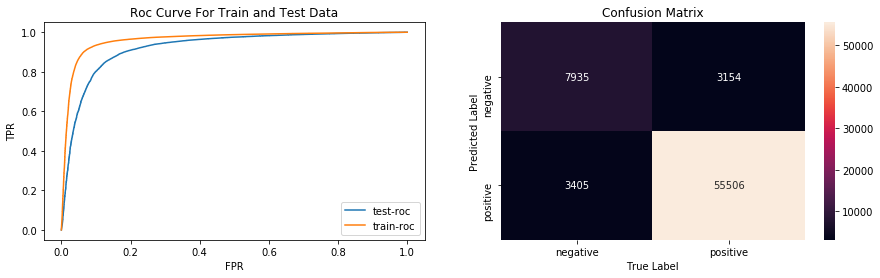

In [278]:
# As we can see that alpha = 0.1 is the right alpha for us in bow
final_model(bow_with_other_features_train,ytr,bow_with_other_features_test,ytest,right_alpha=0.1)

### Term Frequency Inverse Document Frequency

In [258]:
#Using Bag of words on text and summary and adding another feature
import sklearn.feature_extraction.text as textfeat
tfidf = textfeat.TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf.fit(xtr['text+summary'])
tfidf_xtr= tfidf.transform(xtr['text+summary'])
tfidf_xcv = tfidf.transform(xcv['text+summary'])
tfidf_xtest = tfidf.transform(xtest['text+summary'])

In [261]:
tfidf_with_other_features_train = mat.hstack([tfidf_xtr,np.array(xtr['length']).reshape(224000,1)])

In [260]:
tfidf_with_other_features_cv = mat.hstack([tfidf_xcv,np.array(xcv['length']).reshape(56000,1)])

In [259]:
tfidf_with_other_features_test = mat.hstack([tfidf_xtest,np.array(xtest['length']).reshape(70000,1)])

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:15<00:00,  1.98s/it]


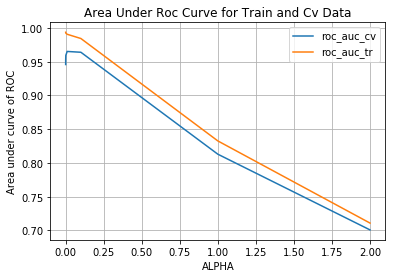

In [262]:
finding_right_alpha_model(tfidf_with_other_features_train,ytr,tfidf_with_other_features_cv,ycv)

*******Final Auc Score is 0.9650310621166116*********
**********Negative Class important features are********
['listtasty' 'mindless' 'mine always' 'mine big' 'container local'
 'mine brought' 'mine eat' 'mine every' 'mine excellent' 'mine fresh']
**********Positive Class important features are********
['unmeasured' 'consumption study' 'rancid imagine' 'moneywaste money'
 'float tasty' 'rancid diet' 'stale tastless' 'stalestale' 'please save'
 'torn tea']


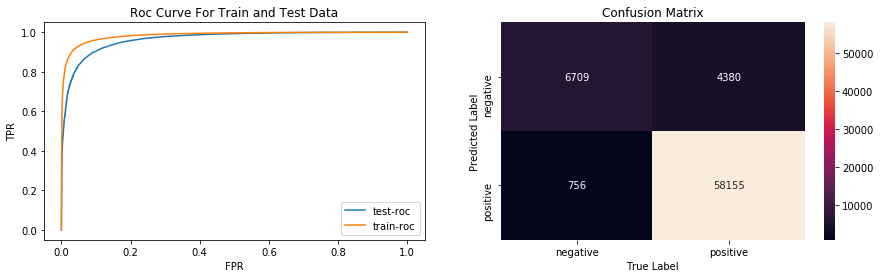

In [279]:
# Training the model with the right parameter = 0.1

nb = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=None)

# fitting the model on crossvalidation train
nb.fit(tfidf_with_other_features_train, ytr)

# predict the response on the crossvalidation train
pred = nb.predict_proba(tfidf_with_other_features_test)[:,1]
pred1 = nb.predict_proba(tfidf_with_other_features_train)[:,1]

#plotting the roc 
final_auc_score= roc_auc_score(ytest,pred)
print("*******Final Auc Score is {}*********".format(final_auc_score))

print("**********Negative Class important features are********")

neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
print(np.take(tfidf.get_feature_names(), neg_class_prob_sorted[:10]))
print("**********Positive Class important features are********")
print(np.take(tfidf.get_feature_names(), pos_class_prob_sorted[:10]))


fpr,tpr,threshold = roc_curve(ytest,pred)
fpr1,tpr1,threshold1 = roc_curve(ytr,pred1)
plt.figure(2,figsize = (15,4))
plt.subplot(1,2,1)
plt.title("Roc Curve For Train and Test Data")
plt.plot(fpr,tpr,label = "test-roc")
plt.plot(fpr1,tpr1,label = "train-roc")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
#plotting the confusion matrix
plt.subplot(1,2,2)
cm = confusion_matrix(ytest,nb.predict(tfidf_with_other_features_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d",center =None)
plt.title("Confusion Matrix")
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

### Because the data is imbalanced, NB is not performing well on Negative class

### Conclusion

In [268]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "Auc-score"]

x.add_row(["Bow", "MultinomialNB", 0.1, 0.9214])
x.add_row(["Tfidf", "MultinomialNB", 0.1, 0.9650])


print(x)

+------------+---------------+----------------+-----------+
| Vectorizer |     Model     | Hyperparameter | Auc-score |
+------------+---------------+----------------+-----------+
|    Bow     | MultinomialNB |      0.1       |   0.9214  |
|   Tfidf    | MultinomialNB |      0.1       |   0.965   |
+------------+---------------+----------------+-----------+
